In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

from keras import backend as K
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
from tqdm import tqdm
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
import matplotlib.cm as cm


In [26]:
# read in image and target datasets
data_path = '/content/drive/MyDrive/compressed_img_target.npz'
loaded_arrays = np.load(data_path)

# Retrieve the arrays
train = loaded_arrays['images']
target = loaded_arrays['target']

**MODEL 3**

In [ ]:
# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# Second split to divide the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [27]:
from keras import backend as K
# Define RMSE loss function
def rmse_custom(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
# Initialising the ImageDataGenerator with specified augmentations
training_data_generator = ImageDataGenerator(
    zoom_range=0.10,  # Randomly increase or decrease the size of the image by up to 10%
    rotation_range=25,  # Randomly rotate the image between -25 to 25 degrees
    width_shift_range=0.05,  # Shift the image along its width by up to +/- 5%
    height_shift_range=0.05,  # Shift the image along its height by up to +/- 5%
    fill_mode='nearest',  # Fill in newly created pixels after a shift or rotation
)

# Creating a generator that will be used for training

train_generator = training_data_generator.flow(
    X_train, y_train,
    batch_size=128
)


In [28]:
def custom_loss(y_true, y_pred):
    lamda = 0.0015
    c1 = tf.abs(tf.reduce_sum(y_pred[:, 0:3], axis=1) - 1) # Class 1 constraint
    c2 = tf.abs(tf.reduce_sum(y_pred[:, 13:15], axis=1) - 1) # Class 6 constraint
    c3 = tf.abs((y_pred[:, 3] + y_pred[:, 4]) - y_pred[:, 1]) # Class 2 constraint
    c4 = tf.abs((y_pred[:, 15] + y_pred[:, 16] + y_pred[:, 17]) - y_pred[:, 10]) # Class 7 constraint
    c5 = tf.abs(tf.reduce_sum(y_pred[:, 18:25], axis=1) - y_pred[:, 13]) # Class 8 constraint
    c6 = tf.abs(tf.reduce_sum(y_pred[:, 25:28], axis=1) - y_pred[:, 3]) # Class 9 constraint
    c7 = tf.abs(tf.reduce_sum(y_pred[:, 5:7], axis=1) - y_pred[:, 4]) # Class 3 constraint
    c8 = tf.abs(tf.reduce_sum(y_pred[:, 7:9], axis=1) - y_pred[:, 4]) # Class 4 constraint
    c9 = tf.abs(tf.reduce_sum(y_pred[:, 28:31], axis=1) - y_pred[:, 7]) # Class 10 constraint
    c10 = tf.abs(tf.reduce_sum(y_pred[:, 9:13], axis=1) - y_pred[:, 7] - y_pred[:, 8]) # Class 5 constraint
    c11 = tf.abs(tf.reduce_sum(y_pred[:, 31:37], axis=1) - y_pred[:, 7]) # Class 11 constraint

    c_loss = lamda*(c1+c2+c3+c4+c5+c6+c7+c8+c9+c10+c11)

    # Base loss (mean squared error)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Combine base loss with constraints (you may need to adjust the weighting)
    return mse_loss + c_loss

In [ ]:
# model architecture

def parallel_cnn3(input_shape, vector_size):
    input_layer = layers.Input(shape=input_shape)

    #  path 1
    path_1 = layers.Conv2D(64, (6, 6), activation='relu', padding='same')(input_layer)
    path_1 = layers.Conv2D(64, (6, 6), activation='relu', padding='same')(path_1)
    path_1 = layers.Conv2D(128, (6, 6), activation='relu', padding='same')(path_1)
    path_1 = layers.BatchNormalization()(path_1)
    path_1 = layers.MaxPooling2D((3, 3), strides=2)(path_1)
    path_1 = layers.Dropout(0.10)(path_1)


    #  path 2
    path_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    path_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(path_2)
    path_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(path_2)
    path_2 = layers.BatchNormalization()(path_2)
    path_2 = layers.MaxPooling2D((3, 3), strides=2)(path_2)
    path_2 = layers.Dropout(0.10)(path_2)

    # Concatenation of frequency and time paths
    concatenated = layers.Concatenate(axis=-1)([path_1, path_2])

    # Convolutional layer 1 after concatenation
    concatenated = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concatenated)
    concatenated = layers.MaxPooling2D((2, 2), strides=2)(concatenated)
    concatenated = layers.Dropout(0.10)(concatenated)

    # Convolutional layer 2
    concatenated_2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated)
    concatenated_2 = layers.MaxPooling2D((2, 2), strides=2)(concatenated_2)
    concatenated_2 = layers.Dropout(0.10)(concatenated_2)

    # Convolutional layer 3
    concatenated_3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concatenated_2)
    concatenated_3 = layers.MaxPooling2D((2, 2), strides=2)(concatenated_3)
    concatenated_3 = layers.Dropout(0.10)(concatenated_3)


    # Flattening and Dense layers with regularization
    flattened = layers.Flatten()(concatenated_3)
    dense_layer = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flattened)
    dense_layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense_layer)
    dense_layer = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense_layer)
    dense_layer = layers.Dropout(0.2)(dense_layer)
    output_layer = layers.Dense(vector_size, activation='sigmoid')(dense_layer)

    # Model creation
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)

In [ ]:
# Compiling the model
input_shape = (64, 64, 3)
vector_size = 37
galaxy_model_3 = parallel_cnn3(input_shape, vector_size)

galaxy_model_3.compile(optimizer='adam', loss = custom_loss, metrics=[RootMeanSquaredError()])
galaxy_model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           6976      ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           147520    ['conv2d[0][0]']              
                                                                                              

In [ ]:
# Training galaxy_model
history_3 = galaxy_model_3.fit(train_generator, validation_data=(X_val, y_val), epochs=300, callbacks=[early_stopping])

Epoch 1/300
289/289 [==============================] - 70s 188ms/step - loss: 0.7495 - root_mean_squared_error: 0.1825 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1533
Epoch 2/300
289/289 [==============================] - 49s 170ms/step - loss: 0.0257 - root_mean_squared_error: 0.1521 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1429
Epoch 3/300
289/289 [==============================] - 49s 170ms/step - loss: 0.0228 - root_mean_squared_error: 0.1443 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1363
Epoch 4/300
289/289 [==============================] - 49s 170ms/step - loss: 0.0208 - root_mean_squared_error: 0.1376 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1342
Epoch 5/300
289/289 [==============================] - 49s 169ms/step - loss: 0.0192 - root_mean_squared_error: 0.1322 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1309
Epoch 6/300
289/289 [==============================] - 49s 169ms/step - loss: 0.0185 - root_mean_squared_error: 0.1298 -

In [ ]:
# Evaluate model
test_loss, test_acc = galaxy_model_3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

385/385 [==============================] - 3s 9ms/step - loss: 0.0107 - root_mean_squared_error: 0.0987
Test accuracy: 0.09865227341651917


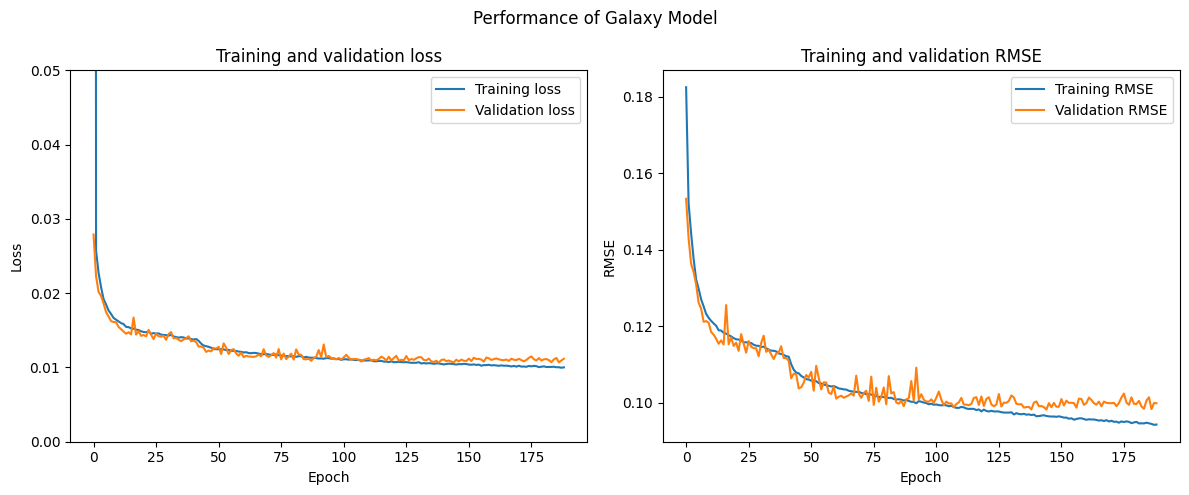

In [ ]:
# Results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(history_3.history['loss'], label='Training loss')
ax1.plot(history_3.history['val_loss'], label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper right')

# Set the y-axis limits
ax1.set_ylim([0, 0.05])

# Plot training and validation RMSE
ax2.plot(history_3.history['root_mean_squared_error'], label='Training RMSE')
ax2.plot(history_3.history['val_root_mean_squared_error'], label='Validation RMSE')
ax2.set_title('Training and validation RMSE')
ax2.set_ylabel('RMSE')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

f.suptitle('Performance of Galaxy Model')
plt.tight_layout()
plt.show()

In [ ]:
galaxy_model_3.save('/content/drive/MyDrive/galaxy_model_4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
from tensorflow.keras.models import load_model

# Loading model
galaxy_model = load_model('/content/drive/MyDrive/galaxy_model_4.h5', custom_objects={'custom_loss': custom_loss})

In [ ]:
predictions = galaxy_model.predict(X_test)

385/385 [==============================] - 6s 8ms/step


In [ ]:

# Calculate the squared differences
squared_differences = tf.square(predictions - y_test)

# Calculate the mean squared error for each position in the vector
mse_per_position = tf.reduce_mean(squared_differences, axis=0)

# Calculate the root mean squared error for each position
rmse_per_position = tf.sqrt(mse_per_position)



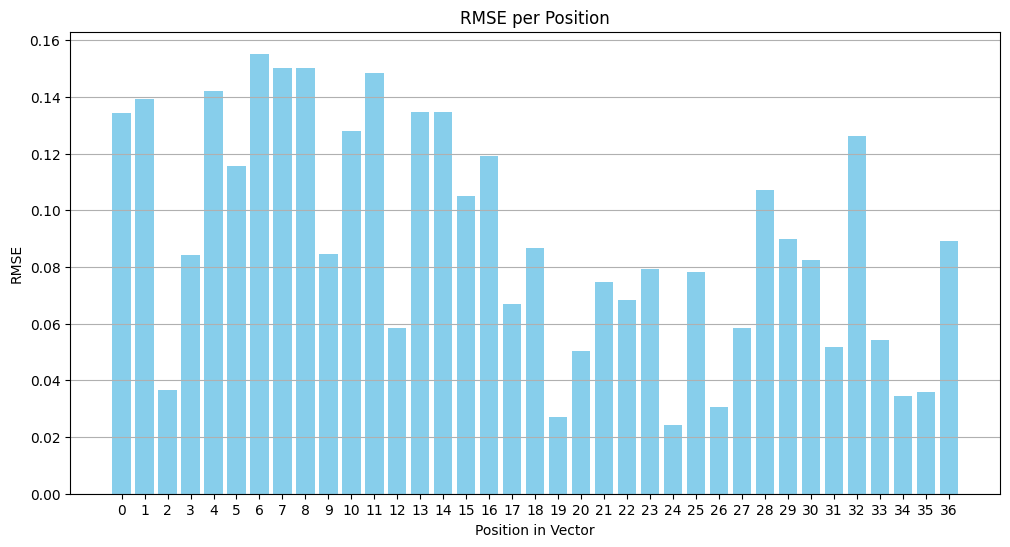

In [ ]:

# Convert rmse_per_position to a numpy array for plotting
rmse_per_position_np = rmse_per_position.numpy()

# Create an array for the positions (0 to 36 if there are 37 positions)
positions = np.arange(len(rmse_per_position_np))

# Plotting using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(positions, rmse_per_position_np, color='skyblue')
plt.title('RMSE per Position')
plt.xlabel('Position in Vector')
plt.ylabel('RMSE')
plt.xticks(positions)
plt.grid(axis='y')
plt.show()


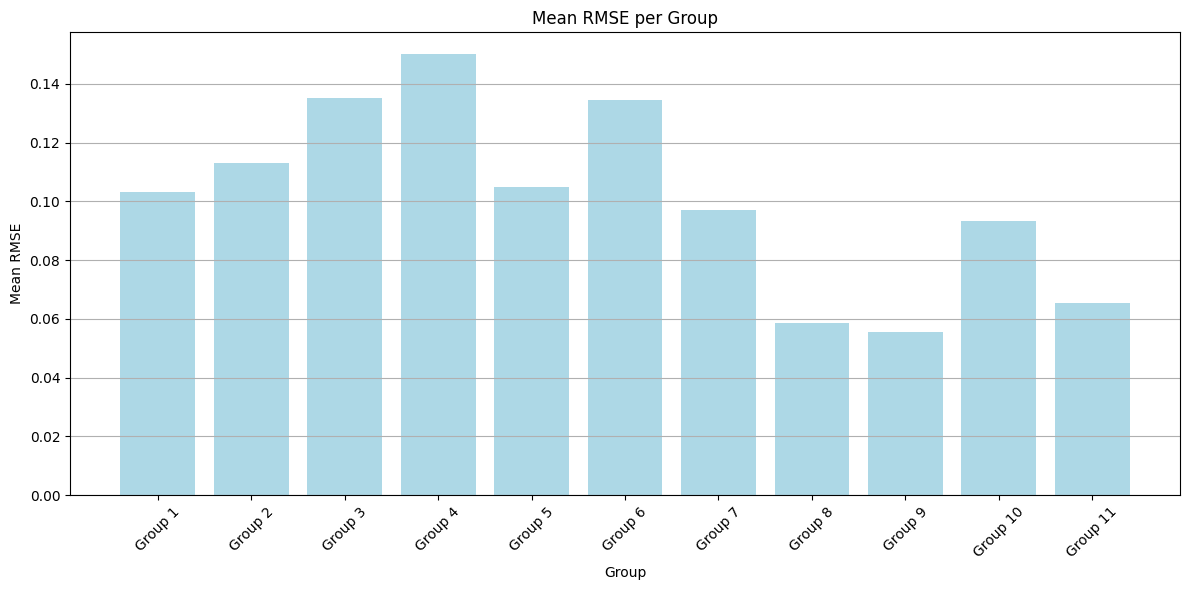

In [ ]:


# Define the groups as per the provided grouping
groups = {
    'Group 1': [0, 1, 2],
    'Group 2': [3, 4],
    'Group 3': [5, 6],
    'Group 4': [7, 8],
    'Group 5': [9, 10, 11, 12],
    'Group 6': [13, 14],
    'Group 7': [15, 16, 17],
    'Group 8': [18, 19, 20, 21, 22, 23, 24],
    'Group 9': [25, 26, 27],
    'Group 10': [28, 29, 30],
    'Group 11': [31, 32, 33, 34, 35, 36],
}

# Calculate the mean RMSE for each group
group_rmse_means = [np.mean(rmse_per_position_np[indices]) for indices in groups.values()]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(groups.keys(), group_rmse_means, color='lightblue')
plt.title('Mean RMSE per Group')
plt.xlabel('Group')
plt.ylabel('Mean RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


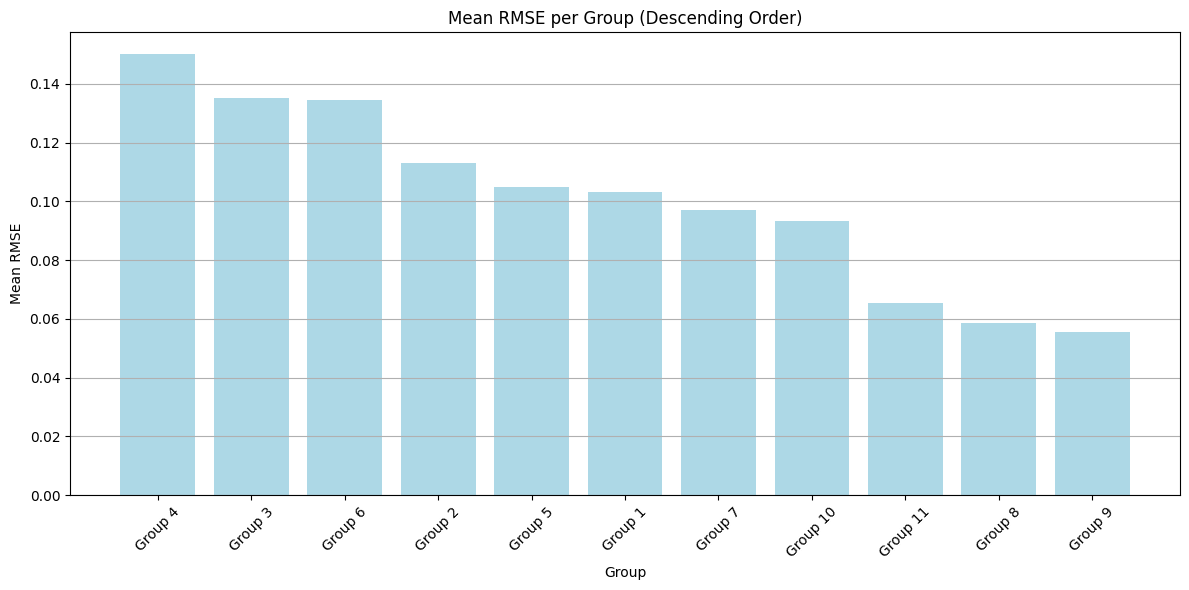

In [ ]:
# Sort the groups based on their mean RMSE, in descending order
sorted_groups = sorted(groups.keys(), key=lambda x: np.mean(rmse_per_position_np[groups[x]]), reverse=True)
sorted_group_rmse_means = [np.mean(rmse_per_position_np[groups[group]]) for group in sorted_groups]

# Plotting in descending order
plt.figure(figsize=(12, 6))
plt.bar(sorted_groups, sorted_group_rmse_means, color='lightblue')
plt.title('Mean RMSE per Group (Descending Order)')
plt.xlabel('Group')
plt.ylabel('Mean RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 35ms/step


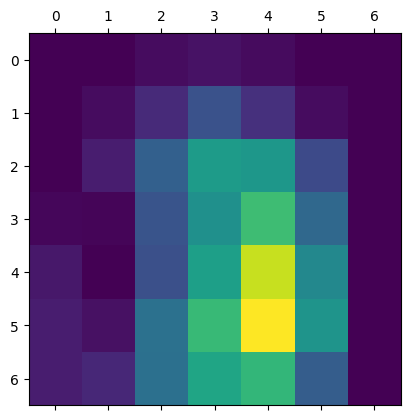

In [62]:
img_array = train[9:10]  # Select an image


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def calculate_range_probabilities(preds, ranges):
    range_probs = []
    for start, end in ranges:
        range_max = tf.reduce_max(preds[0, start-1:end])
        range_probs.append(((start, end), range_max.numpy()))
    return range_probs

# Define your ranges
ranges = [
    (1, 3), (4, 5), (6, 7), (8, 9), (10, 13),
    (14, 15), (16, 18), (19, 25), (26, 28), (29, 31), (32, 37)
]

# Load trained model
model = galaxy_model

# Name of the last conv layer in the model
last_conv_layer_name = 'conv2d_8'

# Generate predictions for the selected image
preds = model.predict(img_array)

# Calculate probabilities for each range
range_probabilities = calculate_range_probabilities(preds, ranges)

# Select a range for Grad-CAM
selected_range = ranges[0]

# Find the pred index within the selected range
selected_probs = preds[0, selected_range[0]-1:selected_range[1]]
pred_index_within_range = np.argmax(selected_probs) + (selected_range[0]-1)

# Generate the heatmap using this pred_index
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index_within_range)

# Display the heatmap
plt.matshow(heatmap)
plt.show()


<ipython-input-63-7d5af532e570>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


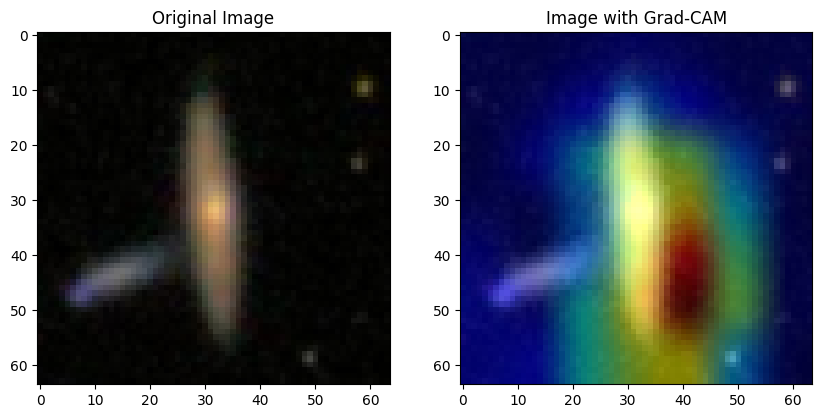

In [63]:
def superimpose_image_and_heatmap(img, heatmap, alpha=0.5):
    """
    Superimpose the heatmap on the original image.

    Args:
    - img (numpy array): The original, colorful image with shape (64, 64, 3).
    - heatmap (numpy array): The Grad-CAM heatmap.
    - alpha (float): Intensity factor for superimposing the heatmap.

    Returns:
    - superimposed_img (PIL Image): The original image superimposed with the heatmap.
    """
    # Using jet colormap to colorize heatmap
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Creating an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimposing the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

# Image number
original_img = train[9].astype('uint8')

# Superimposing the heatmap
superimposed_img = superimpose_image_and_heatmap(original_img, heatmap)

# Display the original image and the one with the heatmap
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(superimposed_img)
ax[1].set_title('Image with Grad-CAM')
plt.show()


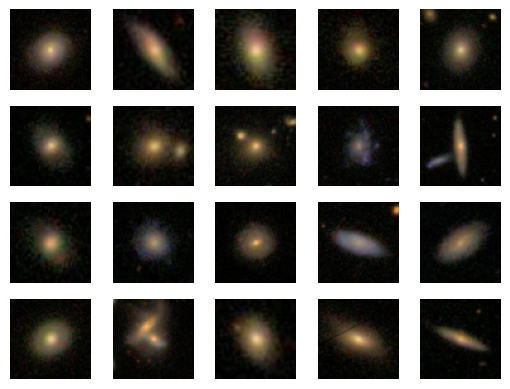

In [41]:
import matplotlib.pyplot as plt

# Assuming 'train' is your list or array of images
for i in range(20):
    plt.subplot(4, 5, i+1)  # Arranges plots in a grid of 4x5
    plt.imshow(train[i])    # Displays image
    plt.axis('off')         # Hides the axis
plt.show()
